# Building the 124M Parameters GPT-2 Model

GPT-2 is a decoder only Transformer model, which means that the encoder and cross-attention modules where missing compared to the figure in **Attention is All You Need**. Also, there are two main differences:
- There is a reshuffling of the layer Norms (Sec 2.3 from GPT-2 paper). Layer Norms were moved to the input of each sub-block, similar to a pre-activation residual network.
- An additional layer norm was added after the final self-attn block (hight before the final classifier).

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import inspect
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from tqdm import tqdm

In [2]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

# GPT-2 Model Configuration

In [3]:
@dataclass
class GPTConfig:
    block_size:int= 1024  # max sequence length
    vocab_size:int= 50257 # number of tokens: 50k BPE merges + 256 bytes tokens + 1 <|endoftext|>
    n_layer:int= 12       # number of layers
    n_head:int= 12        # number of heads
    n_embed:int= 768      # embedding dimension



# Input Embedding

An embedding is a mapping of discrete objects, such as words, phrases, or documents, into a continuous vector space. In this space, semantically similar items are located close to each other. This is achieved by training machine learning models on large corpora of text data to learn patterns and contexts in which words or phrases appear.

- **Token Embedding**: 50257 tokens in the vocabulary size, and for each token we have a 768 dimensional embedding that is the distributed representation that stands in for that tokens. Each token is a little string piece and then the 768 numbers are the vector that represents that token. So, this is our lookup table for tokens.
- **Positional Embedding**: 1024 x 768 dimensional lookup table. GPT-2 has a maximum sequence length of 1024; so, we have 1024 positions that each token can be attending to in the past. Everyone of those positions in GPT-2 has a fized vector of 768 weights learned by optimization. Each of the 1024 rows represent the positions of tokens and it is precessed by the Transformer to recover all the relative positions and realizer which token is where and attend to them depending on their position, not just their content. In the **Attention is All You Need** paper the positional embedding is initialized with cosine and sine of different frequencies and it is fixed, but in GPT-2 these are just parameters and they are trained from scratch.


# Decoder Block

There is multiple Attention heads inside a Decoder block and they are all functioning in parallel, their outputs are just being concatenated, and that becomes the output of Multi-Headed Attention. The heads are like parallel streams and their outputs get concatenated.

**FlashAttention (FA)** is a kernel fusion operation that makes the Attention implementation faster by avoiding loads and stores that torch.compile is not able to optimize. It relies on a "online softmax" trick (page 4 of FA paper) that incrementally evaluates softmax.

https://arxiv.org/abs/2205.14135



In [4]:
class CausalSelfAttention(nn.Module):
    """
    Defining the Attention operation.
    """

    def __init__(self, config) -> None:
        super(CausalSelfAttention, self).__init__()
        assert config.n_embed % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn= nn.Linear(config.n_embed, 3 * config.n_embed)
        # output projection
        self.c_proj= nn.Linear(config.n_embed, config.n_embed)
        self.c_proj.GPT_SCALE_INIT= 1
        # regularization
        self.n_head = config.n_head
        self.n_embed= config.n_embed
        """
        # register_buffer is only required for the original implementation of Attention
        # not really a 'bias', more a mask, but following the OpenAI/HF naming
        self.register_buffer('bias',
            torch.tril(torch.ones(config.block_size, config.block_size))
            .view(1, 1, config.block_size, config.block_size)
        )
        """


    def forward(self, x):
        B, T, C= x.size() # batch_size, sequence_length, embedding dim (n_embed)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is 'number of heads', hs is 'head size', and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head= 12, hs= 64, so nh*hs=C=768 channels in the Transformer
        qkv= self.c_attn(x)
        q, k, v= qkv.split(self.n_embed, dim=2)
        k= k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q= q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v= v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        # Attention (materializes the large (T,T) matrix for all the queries and keys)
        """
        # this is the original implementation of Attention
        att= (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att= att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att= F.softmax(att, dim=-1)
        y= att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        # and the following implements FlashAttention
        """
        y= F.scaled_dot_product_attention(q, k, v, is_causal=True)
        y= y.transpose(1, 2).contiguous().view(B, T, C) # re-assembly all head outputs side by side
        # output projection
        y= self.c_proj(y)

        return y


Tokens are lined up in a sequence and each token at this stage of the attention emits three vectors, the query, key, and value. First, the queries and the keys have to multiply each other to get the Attention amount like how interesting they found each other; so, they have to interact multiplicatively.

After calculating and splitting qkv, we make the number of heads nh into a batch dimension, and it is a batch dimension just like B. So, in the operations that follow, PyTorch treats B and nh as batches and it applies all the operations on all of them in parallel in both the batches and the heads. Next, queries and keys interact to give us their attention. The autoregressive mask makes sure that the tokens only attend to tokens before them and never to tokens in the future. Softmax normalizes the attention (so, it sums to one). Then, the attention matrix (att) multiply with the values, which is basically a way to do a weighted sum of the values of the tokens that we found interesting at every single tokens. The last transpose operation performs the concatenation operation.

In [5]:
class MLP(nn.Module):
    """
    Defining the MLP (aka FeedForward).
    It is a two linear projectons sandwiched in between the GELU nonlinearity approximating
    a tanh (basically like a ReLU except there is no exactly flat tail at zero). Today there is
    no good reason to use the approximate version of GELU (but GPT-2 used it).
    https://arxiv.org/abs/1606.08415
    """

    def __init__(self, config) -> None:
        super(MLP, self).__init__()
        self.c_fc=   nn.Linear(config.n_embed, 4 * config.n_embed)
        self.gelu=   nn.GELU(approximate='tanh')
        self.c_proj= nn.Linear(4 * config.n_embed, config.n_embed)
        self.c_proj.GPT_SCALE_INIT= 1


    def forward(self, x):
        x= self.c_fc(x)
        x= self.gelu(x)
        x= self.c_proj(x)

        return x


Attention is a communication operation. It is where the tokens and the 1024 positional tokens lined up in a sequence and this is where tokens communicate, this is where they exchange information. Attention is an aggregation function, it is like a pooling (reducing operation) function or a weghted sum function. The MLP happens at every single token individually, i.e., there is no information being collected or exchanged between the tokens. Therefore, the Attention is the reduce and the MLP is the map.

The Transformer just ends up being a repeated application of map produce. MLP is thinking about the information that Attention gathered. The sequence of decoder blocks iteratively refines the representation is at the residual stream.

In [6]:
class DecoderBlock(nn.Module):
    """
    Defining the Decoder. Pre-normalization version.
    LayerNorms are before the application of Attention and FeedForward in order to keep
    a clean residual stream all the way down to the input tokens.
    """

    def __init__(self, config) -> None:
        super(DecoderBlock, self).__init__()
        self.ln_1= nn.LayerNorm(config.n_embed)
        self.attn= CausalSelfAttention(config)
        self.ln_2= nn.LayerNorm(config.n_embed)
        self.mlp = MLP(config)


    def forward(self, x):
        x= x + self.attn(self.ln_1(x))
        x= x + self.mlp(self.ln_2(x))

        return x


# Build the GPT-2 Model

In [7]:
class GPT2(nn.Module):
    """
    GPT-2 architecture skeleton.
    """

    def __init__(self, config) -> None:
        super(GPT2, self).__init__()
        self.config= config
        # ModuleDict allows us to index submodules using keys just like a dictionary
        # ModuleList indexes itens using integers
        self.transformer= nn.ModuleDict(dict(
            wte= nn.Embedding(config.vocab_size, config.n_embed), # Token Embedding
            wpe= nn.Embedding(config.block_size, config.n_embed), # Positional Embedding
            h= nn.ModuleList([DecoderBlock(config) for _ in range(config.n_layer)]),
            ln_f= nn.LayerNorm(config.n_embed)
        )) # projection from n_embed numbers of embedding dimensions to vocab_size
        self.lm_head= nn.Linear(config.n_embed, config.vocab_size, bias=False)
        # weight sharing scheme
        self.transformer.wte.weight= self.lm_head.weight
        # init params by iterating over them
        self.apply(self._init_weights)


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std= 0.02
            if hasattr(module, 'GPT_SCALE_INIT'):
                # std scaling down -- we have two residual connections per decoder block
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias) # zeros init is not default in PyTorch
        elif isinstance(module, nn.Embedding):    # 0.02 is close of that used in xavier init
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)


    def forward(self, idx, targets=None):
        # idx is our token indices of shape (B, T)
        B, T= idx.size()
        assert T <= self.config.block_size, f'Cannot forward sequence of length {T}, block size is only {self.config.block_size}'
        # forward the token and the position embeddings
        pos= torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb= self.transformer.wpe(pos) # position embeddings of shape (T, n_embed)
        tok_emb= self.transformer.wte(idx) # token embeddings of shape (B, T, n_embed)
        x= tok_emb + pos_emb # pos_emb is broadcasted at every row stacked up in tok_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x= block(x)
        # forward the final layernorm and the classifier
        x= self.transformer.ln_f(x)
        logits= self.lm_head(x) # (B, T, vocab_size)
        # at every B by T we will calculate the logits for what tokens come next in the sequence
        loss= None
        if targets is not None:
            loss= F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
            # we are flattening out 3D logits tensor into 2D (B*T, vocab_size)
        return logits, loss


    @classmethod
    def from_pretrained(cls, model_type):
        """
        Loads pretrained GPT-2 model weights from HF.
        """

        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print('Loading weights from pretrained GPT: %s' % model_type)

        # n_layer, n_head, and n_embed are determined from model_type
        config_args= {
            'gpt2':        dict(n_layer=12, n_head=12, n_embed=768),  #  124M params
            'gpt2-medium': dict(n_layer=24, n_head=16, n_embed=1024), #  350M params,
            'gpt2-large':  dict(n_layer=36, n_head=20, n_embed=1280), #  774M params,
            'gpt2-xl':     dict(n_layer=48, n_head=25, n_embed=1600), # 1558M params,
        }[model_type]
        config_args['vocab_size']= 50257 # always 50257 for GPT models
        config_args['block_size']= 1024  # always 1024 for GPT models
        # create a from-scratch initializated miniGPT model
        config= GPTConfig(**config_args)
        model= GPT2(config)
        sd= model.state_dict()
        sd_keys= sd.keys()
        sd_keys= [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask

        # init a HF/Transformers model
        model_hf= GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf= model_hf.state_dict()

        # copy while ensuring all the parameters are aligned and match in names and shapes
        sd_keys_hf= sd_hf.keys()
        sd_keys_hf= [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # just a buffer
        sd_keys_hf= [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same
        transposed= ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the OpenAI checkpoints use a 'Conv1D' module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"Mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for thr Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model


    def configure_optimizers(self, weight_decay, learning_rate, device):
        """
        Splitting up the parameters tha should be weight decayed and those that should not.
        Weight decay acts like a regularization because we're pulling down all the weights,
        forcing the optimization to more of the weights and not allowing any one of the weights
        individually to be way too large (we're forcing the network to distribute the work across)
        more channels because there is a pull of gravity on the weights themselves.
        """
        # start with a lot of the candidate parameters (that require grad)
        param_dict= {pn: p for pn, p in self.named_parameters()}
        param_dict= {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any 2D parameters will be weight dacayed, otherwise no
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layerNorms don't
        # but most of the parameters will be decayed
        decay_params  = [p for n, p in param_dict.items() if p.dim()>= 2]
        nodecay_params= [p for n, p in param_dict.items() if p.dim() < 2] # one-dim tensors
        optim_groups= [
            {'params':   decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params  = sum(p.numel() for p in decay_params)
        num_nodecay_params= sum(p.numel() for p in nodecay_params)
        print(f"Num decayed parameter tensors: {len(decay_params)}, with {num_decay_params} parameters")
        print(f"Num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params} parameters")
        # create AdamW optimizer and use the fused version of it is available
        fused_available= 'fused' in inspect.signature(torch.optim.AdamW).parameters
        # fused is a lot faster when it is available and when running on cuda
        use_fused= fused_available and device== "cuda"
        print(f"Using fused AdamW: {use_fused}")
        # create a AdamW PyTorch optimizer -- bug fix of Adam
        optimizer= torch.optim.AdamW(
            optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused
        )
        return optimizer


In [8]:
# creating a model with random initialization
model= GPT2(GPTConfig())
model

GPT2(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x DecoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='tanh')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [9]:
total_params= sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {total_params}')

Number of parameters: 124439808


# Generating Some Text Sequences

Loading the weights, biases, and everithing else from HF to our model.

In [ ]:
!pip install tiktoken

# prefix tokens using tiktoken
import tiktoken

In [12]:
num_return_sequences= 5
max_length= 30

model= GPT2.from_pretrained('gpt2').to(device)

Loading weights from pretrained GPT: gpt2


In [14]:
# getting a list of integer encoding the following string
enc= tiktoken.get_encoding('gpt2')
tokens= enc.encode("Hello, I'm a language model,")
tokens= torch.tensor(tokens, dtype=torch.long) # (8,)
tokens= tokens.unsqueeze(0).repeat(num_return_sequences, 1) # (5,8)
x= tokens.to(device)

# generate! right now x is (B, T -- batch x time) where B= 5, T= 8
# set the seed to 42
if device== 'cuda':
    torch.cuda.manual_seed(42)
else:
    torch.manual_seed(42)

model.eval()
while x.size(1) < max_length:
    # forward the model to get the logits -- in every iteration we're going to be adding a
    # column of new indices (by resampling) into each one of the rows in x
    with torch.no_grad():
        logits, loss= model(x) # (B, T, vocab_size)
        # take the logits at the last position
        logits= logits[:, -1, :] # (B, vocab_size)
        # get the probabilities
        probs= F.softmax(logits, dim=-1)
        # do top-k sampling of 50 (HF pipeline default) -- we only want to keep the top 50
        # most likely tokens; so, that way we are never sampling very rare tokens
        # topk_probs here becomes (5, 50), topk_indices is (5, 50)
        topk_probs, topk_indices= torch.topk(probs, 50, dim=-1)
        # select a token from the top-k probabilities
        ix= torch.multinomial(topk_probs, 1) # (B, 1)
        # gather the corresponding indices
        xcol= torch.gather(topk_indices, -1, ix) # (B, 1)
        # append to the sequence
        x= torch.cat((x, xcol), dim=1)
# print the generated text
for i in range(num_return_sequences):
    tokens= x[i, :max_length].tolist()
    decoded= enc.decode(tokens)
    print(">", decoded)


> Hello, I'm a language model, not a programming platform! I just make decisions based on other projects. I try to do that."


> Hello, I'm a language model, a kind of a "first class citizen" of the world and a person that comes from a much more egalitarian
> Hello, I'm a language model, and I'm starting to talk about the notion of the syntax, and I'm also working on an extension that
> Hello, I'm a language model, because I'm writing real-time. I'm writing all languages. And I'm working with languages for me
> Hello, I'm a language model, I don't know where to begin but I know there is a big deal going on with our society. What


# Training the Model from Scratch

Using a tine (and nice dataset for debugging) to get us off the ground. We are going to encode the dataset using tiktoken for GPT2 in order to transform our data into sequences of integer tokens, process these token sequences and feed them into a Transformer by rearranging these tokens into the **idx** variable that we're going to be feeding into the Transformer. Specifically, we don't want a single very long onedimensional sequence, but an entire batch where each sequence is up to **T** tokens and **T** cannot be larger than the maximum sequence length (i.e., T-long sequences of tokens and B independent examples of sequences).

In [11]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

# read it in to inspect
with open('input.txt', 'r', encoding='utf-8') as f:
    text= f.read()

--2024-11-17 11:28:12--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2024-11-17 11:28:13 (17.2 MB/s) - ‘input.txt’ saved [1115394/1115394]



We can create the data batches by rearranging our dataset using a view operation. Regarding the labels we need for the target to calculate the loss function, we get that as the next token in a sequence (the right of the current one), but notice we don't have a next token for the last one in a sequence, indeed it is the first one of the next sequence.

In [ ]:
tokens= enc.encode(text)
buf= torch.tensor(tokens[:24 + 1]) # +1 in order to have the last label
x= buf[:-1].view(4, 6)
y= buf[1:].view(4, 6)

print(x) # input tensors
print(y) # labels

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])
tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])


In [ ]:
# making more clean
tokens= enc.encode(text)
B, T= 4, 32 # batch_size and seq_len
buf= torch.tensor(tokens[:B*T + 1]).to(device) # +1 in order to have the last label
x= buf[:-1].view(B, T)
y= buf[1:].view(B, T)

In [ ]:
# get logits
model= GPT2(GPTConfig()).to(device)
model.eval()
logits, loss= model(x, y)

print(logits.shape)
print(loss) # expected loss -ln(1/50257) ~ 10.8249 (cross entropy is the negative log likelihood)

torch.Size([4, 32, 50257])
tensor(11.0581, grad_fn=<NllLossBackward0>)


In [12]:
class DataLoaderLite:
    """
    Read the data, tokenize it and build batches of sentences.
    next_batch function return two tensors on device for training, x and y
    y is the target of x, i.e, containing the next token for prediction.
    """

    def __init__(self, B, T, data_file, device, process_rank, num_processes) -> None:
        self.B= B
        self.T= T
        self.device= device
        self.process_rank= process_rank
        self.num_processes= num_processes

        # at init load tokens from disk and store them in the memory
        with open(data_file, 'r') as f:
            text= f.read()
        self.encoder= tiktoken.get_encoding('gpt2')
        tokens= self.encoder.encode(text)
        self.tokens= torch.tensor(tokens)
        print(f'Loaded {len(self.tokens)} tokens')
        print(f'1 epoch = {len(self.tokens) // (B * T)} batches')
        # state -- we want to stride out all the processes, i.e., process 0 starts at 0,
        # but process rank 1 starts at B*T*1, ...
        self.current_position= B * T * process_rank


    def next_batch(self):
        B, T= self.B, self.T
        buf= self.tokens[self.current_position : self.current_position+B*T+1]
        x= (buf[:-1]).view(B, T) # inputs
        y= (buf[1:]).view(B, T)  # targets
        # advance the position in the tensor
        self.current_position += B * T * self.num_processes
        # if loading the next token would be out of bounds, reset
        if self.current_position + (B * T * self.num_processes + 1) > len(self.tokens):
            self.current_position= B * T * self.process_rank

        return x.to(device), y.to(device)


In [13]:
class Cosine_LR_Decay:
    """
    Modulates learning rate (LR) based on the iteration number which LR there should be.
    """

    def __init__(self, optimizer, min_lr, max_lr=3e-4, warmup_steps=10,
                 max_steps=50) -> None:
        self.optimizer= optimizer
        self.min_lr= min_lr
        self.max_lr= max_lr
        self.warmup_steps= warmup_steps
        self.max_steps= max_steps
        self.last_lr= None


    def get_last_lr(self):
        return self.last_lr


    def get_lr(self, it):
        # 1) linear warmup for warmup_iters steps
        if it< self.warmup_steps:
            return self.max_lr * (it+1) / self.warmup_steps
        # 2) if it > lr_decay_iters, return min learning rate
        if it> self.max_steps:
            return self.min_lr
        # 3) in between, use cosine decay down to min learning rate
        decay_ratio= (it - self.warmup_steps) / (self.max_steps - self.warmup_steps)
        assert 0 <= decay_ratio <= 1
        # coeff starts at 1 and goes to 0
        coeff= 0.5 * (1.0 + math.cos(math.pi * decay_ratio))

        return self.min_lr + coeff * (self.max_lr - self.min_lr)


    def step(self, it):
        self.last_lr= self.get_lr(it)
        for param_group in self.optimizer.param_groups:
            param_group['lr']= self.last_lr


**Gradient accumulation:** simulate in a serial way any arbitrary batch size that we set and so we can do a very large batch size running longer and processing multiple sequences and adding up all the gradients from them to simulate a large batch size.

**DDP:** in a forward pass it behaves identically, nothing should be changedd in the forward pass, but in the backward pass, once the backward passes over on each independent GPU, each of them has the gradient for all the parameters and what DDP does is once the backward pass is over it will call the "all reduce" and it does an average across all the ranks of their gradients. Then, it will deposit that average on every single, which ends up with with the average on it. So, DDP synchronizes and averages the gradients.

In [14]:
import time

def self_supervised_training(model, train_loader, optimizer, scheduler, steps,
                             grad_accum_steps, ddp, ddp_rank, master_process,
                             use_compile, eval_interval=200):
    tr_loss_hist= []

    # --- training loop ---
    for step in range(steps):
        start= time.time()
        last_step= (step== steps-1)

        # --- once in a while generate from the model (except step 0, which is noise)
        if ((step> 0 and step % eval_interval==0) or last_step) and (not use_compile):
            model.eval()
            enc= train_loader.encoder
            num_return_sequences= 4
            max_length= 32
            tokens= enc.encode("Hello, I'm a language model,")
            tokens= torch.tensor(tokens, dtype=torch.long)
            tokens= tokens.unsqueeze(0).repeat(num_return_sequences, 1)
            xgen= tokens.to(device)
            sample_rng= torch.Generator(device=device)
            sample_rng.manual_seed(42 + ddp_rank)
            # same code as seen before in "Generating Some Text Sequences"
            while xgen.size(1) < max_length:
                # forward the model to get the logits -- in every iteration we're going to be adding a
                # column of new indices (by resampling) into each one of the rows in x
                with torch.no_grad():
                    logits, _= model(xgen) # (B, T, vocab_size)
                    # take the logits at the last position
                    logits= logits[:, -1, :] # (B, vocab_size)
                    # get the probabilities
                    probs= F.softmax(logits, dim=-1)
                    # do top-k sampling of 50 (HF pipeline default) -- we only want to keep the top 50
                    # most likely tokens; so, that way we are never sampling very rare tokens
                    # topk_probs here becomes (5, 50), topk_indices is (5, 50)
                    topk_probs, topk_indices= torch.topk(probs, 50, dim=-1)
                    # select a token from the top-k probabilities
                    ix= torch.multinomial(topk_probs, 1, generator=sample_rng) # (B, 1)
                    # gather the corresponding indices
                    xcol= torch.gather(topk_indices, -1, ix) # (B, 1)
                    # append to the sequence
                    xgen= torch.cat((xgen, xcol), dim=1)
            # print the generated text
            for i in range(num_return_sequences):
                tokens= xgen[i, :max_length].tolist()
                decoded= enc.decode(tokens)
                print(f"Rank {ddp_rank} sample {i}: {decoded}")


        # --- training step ---
        model.train(True)
        optimizer.zero_grad()
        loss_accum= 0.0

        # iterating over all batches accumulating gradients
        for micro_step in range(grad_accum_steps):
            # --- minibatch construction ---
            Xmb, Ymb= train_loader.next_batch()

            # --- forward pass and get loss ---
            # DDP does the backward pass and synchronizes the gradient
            if ddp: # backward_grad_sync only turns on (True) when the micro_step is the last
                model.require_backward_grad_sync= (micro_step== grad_accum_steps-1)
            logits, loss= model(Xmb, Ymb)

            # --- gradient pass to calculate the gradients ---
            """ the loss reduction is the mean by default. We need to compensate it by
            the number of gradient accumulation steps before accumulating on each backward().
            addition of grads corresponds to a SUM in the objective, but instead of a SUM
            we want MEAN. Scale the loss here so it comes out right """
            loss= loss / grad_accum_steps
            loss_accum += loss.detach()
            loss.backward() # this is a plus equals, i.e., accumulates the grads
        if ddp:
            """ reduce the accum loss over all the processes to the average over that loss
            the loss_accum tensor exists on all the ranks, when we call all_reduce of AVG it
            creates the average of those numbers and deposits that average on all the ranks"""
            dist.all_reduce(loss_accum, op=dist.ReduceOp.AVG)
        """ calculating the global norm of the parameters to preventing the model from getting
        too big shocks in terms of gradient magnitude """
        norm= torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # determine and set the learning rate for this interaction
        scheduler.step(step)

        # --- update the parameters ---
        optimizer.step()

        # --- evaluation and track stats ---
        if Xmb.device.type== 'cuda':
            torch.cuda.synchronize() # wait for the GPU to finish work
        end= time.time()
        dt= end - start # time difference in seconds
        tokens_processed= train_loader.B * train_loader.T * grad_accum_steps * ddp_world_size
        tokens_per_sec= tokens_processed / dt
        if master_process:
            tr_loss_hist.append(loss_accum.item())
            print(f"Step {step:4d} | loss: {loss_accum.item():.4f} | lr: {scheduler.get_last_lr():.3e} | dt: {dt*1000:.2f}ms | tok/sec: {tokens_per_sec:.1f}")

    return tr_loss_hist


TF32 uses the same 10-bit mantissa as the half-precision (FP16) math, shown to have more than sufficient margin for the precision requirements of AI workloads. And TF32 adopts the same 8-bit exponent as FP32 so it can support the same numeric range.

Torch.compile(model) will analyze the entire model and look at what operations we like to use and with the benefit of knowing exactly what is going to happen. It materializes all the operations as it goes through and the calculations are dispatched and run in order. Specifically, the Python interpreter does not know what kind of operations are going to happen later, but torch.compile sees your code entirely at the same time, and it is able to know what operations are intended to run, and it will optimize that process. As a result, torch.compile significantly optimizes the round trips between GPU cores and memory, what is called **kernel fusion** (a major way in speed up).

**Values optimization:** fixing ugly numbers (odds or not power of two) through the model. We increase a value to the next nice number.
- vocab_size: from 50257 (ugly) to 50304 (nice). Additional "fake" tokens we are introducing will never be used and have to be driven to zero in probability.

In [ ]:
!pip install triton

In [16]:
"""
INIT DDP
simple launch:
python file_name.py
DDP launch for 8 GPUs:
torchrun --standalone --nproc_per_node=8 file_name.py
"""

from torch.distributed import init_process_group, destroy_process_group
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist

# set up DDP (distributed data parallel)
# torchrun command sets the env variables RANK, LOCAL_RANK, and WORLD_SIZE
ddp= int(os.environ.get('RANK', -1))!= -1
print(f"Is this a ddp run? {ddp}")
if ddp:
    # use of DDP atm demands CUDA, we set the device appropriately according to rank
    assert torch.cuda.is_available(), "For now we need CUDA for DDP"
    init_process_group(backend='nccl')
    # create environ where each of these processes can look up
    ddp_rank= int(os.environ['RANK'])
    ddp_local_rank= int(os.environ['LOCAL_RANK'])
    ddp_world_size= int(os.environ['WORLD_SIZE'])
    device= f'cuda:{ddp_local_rank}'
    torch.cuda.set_device(device)
    master_process= ddp_rank== 0 # this process will do logging, checkpoiniting
else:
    # vanilla non-DDP run
    ddp_rank= 0
    ddp_local_rank= 0
    ddp_world_size= 1
    master_process= True
    # attempt to autodetect device
    device= 'cuda' if torch.cuda.is_available() else 'cpu'


torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)


Is this a ddp run? False


In [17]:
total_batch_size= 16*1024 * 2
B= 16    # micro batch size
T= 1024  # sequence length

assert total_batch_size % (B * T * ddp_world_size)== 0, "Make sure total_batch_size is divisible by B * T * ddp_world_size"
grad_accum_steps= total_batch_size // (B * T * ddp_world_size)
if master_process: # only the master_process will print it, otherwise all process will print
    print(f"Total desired batch size: {total_batch_size}")
    print(f"=> calculated gradient accumulation steps: {grad_accum_steps}")
"""
We have B x T sequences to forward and backward the Transformer but we are not going to do an
update. We're goiing to do many forward and backwards and those gradients are all going to be
accumulated on the parameter gradients for a single update once all that is accumulated.
So, we have to do grad_accum_steps forward backward and then a single update
"""

train_loader= DataLoaderLite(B=B, T=T, data_file='input.txt', device=device,
                             process_rank=ddp_rank, num_processes=ddp_world_size)

if device== 'cuda': # TF32 computationally more efficient (slightly the same precision of FP32)
    torch.set_float32_matmul_precision('high')

# create model
model= GPT2(GPTConfig(vocab_size=50304)).to(device)
use_compile= False # torch.compile interferes with Generation. TODO fix
if device== 'cuda' and use_compile:
    model= torch.compile(model)
if ddp:
    # wrap the model into the DDP container
    model= DDP(model, device_ids=[ddp_local_rank])
raw_model= model.module if ddp else model # always contains the raw unwrapped model

learning_rate=6e-4
steps=500

max_lr= learning_rate
min_lr= max_lr * 0.1
warmup_steps= 10
max_steps= steps

optimizer= raw_model.configure_optimizers(
    weight_decay=0.1, learning_rate=learning_rate, device=device
)

scheduler= Cosine_LR_Decay(optimizer, min_lr, max_lr, warmup_steps, max_steps)

loss_hist= self_supervised_training(model, train_loader, optimizer, scheduler, steps,
                         grad_accum_steps, ddp, ddp_rank, master_process,
                         use_compile, eval_interval=100)

if ddp:
    destroy_process_group()


Total desired batch size: 32768
=> calculated gradient accumulation steps: 2
Loaded 338025 tokens
1 epoch = 20 batches
Num decayed parameter tensors: 50, with 124354560 parameters
Num non-decayed parameter tensors: 98, with 121344 parameters
Using fused AdamW: True
Step    0 | loss: 10.9402 | lr: 6.000e-05 | dt: 1783.87ms | tok/sec: 18369.0
Step    1 | loss: 9.6733 | lr: 1.200e-04 | dt: 438.09ms | tok/sec: 74797.1
Step    2 | loss: 9.2101 | lr: 1.800e-04 | dt: 438.90ms | tok/sec: 74660.0
Step    3 | loss: 9.8826 | lr: 2.400e-04 | dt: 438.54ms | tok/sec: 74720.0
Step    4 | loss: 9.2471 | lr: 3.000e-04 | dt: 439.30ms | tok/sec: 74590.6
Step    5 | loss: 8.7262 | lr: 3.600e-04 | dt: 440.02ms | tok/sec: 74469.3
Step    6 | loss: 8.3843 | lr: 4.200e-04 | dt: 439.99ms | tok/sec: 74474.4
Step    7 | loss: 8.1466 | lr: 4.800e-04 | dt: 439.40ms | tok/sec: 74574.8
Step    8 | loss: 7.8399 | lr: 5.400e-04 | dt: 439.71ms | tok/sec: 74521.7
Step    9 | loss: 7.4582 | lr: 6.000e-04 | dt: 440.18ms |

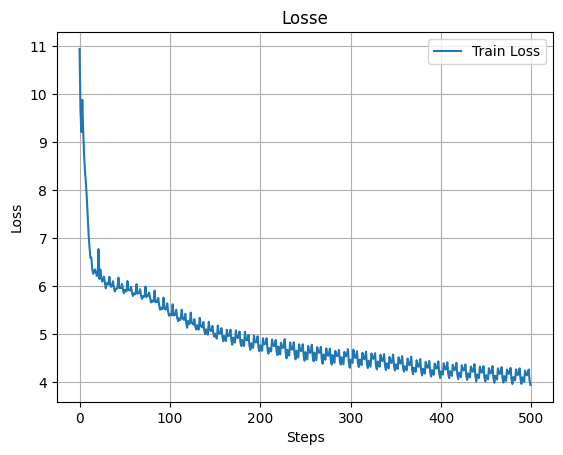

In [18]:
# Plot
plt.plot(loss_hist, label='Train Loss')
plt.title('Losse')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# FineWeb-Edu dataset

Using the sample-10BT: a subset randomly sampled from the whole dataset of around 10B gpt2 tokens.

https://huggingface.co/datasets/HuggingFaceFW/fineweb-edu

In [ ]:
"""
DATA HANDLER FOR FineWeb-Edu dataset
Downloading the dataset, tokenizing all the documents inside this dataset, starting with an eot
token, encoding using uint16 to save space. Then, the tokenized datased is saved into shards (numpy
files very similar to tensors).
"""

!pip3 install datasets

import multiprocessing as mp
from datasets import load_dataset

local_dir= "edu_fineweb10B"
remote_name= "sample-10BT"
shard_size= int(1e8) # 100M tokens per shard, total of 100 shard files

# create the cache the local directory if it doesn't exist yet
#DATA_CACHE_DIR= os.path.join(os.path.dirname('__init__'), local_dir)
DATA_CACHE_DIR= os.path.join(os.path.dirname('data/'), local_dir)
os.makedirs(DATA_CACHE_DIR, exist_ok=True)

# download the dataset
fw= load_dataset("HuggingFaceFW/fineweb-edu", name=remote_name, split="train")

# init the tokenizer
enc= tiktoken.get_encoding("gpt2")
eot= enc._special_tokens['<|endoftext|>'] # end of text token
def tokenize(doc):
    # tokenizes a single document and returns a numpy array of uint16 tokens
    tokens= [eot] # the special <|endoftext|> token delimits all documents
    tokens.extend(enc.encode_ordinary(doc["text"]))
    tokens_np= np.array(tokens)
    assert (0 <= tokens_np).all() and (tokens_np < 2**16).all(), "token dictionary too large for uint16"
    tokens_np_uint16= tokens_np.astype(np.uint16)
    return tokens_np_uint16

def write_datafile(filename, tokens_np):
    np.save(filename, tokens_np)


In [ ]:
# tokenize all documents and write output shards, each of shard_size tokens (last shard has remainder)
nprocs= max(1, os.cpu_count()//2)
with mp.Pool(nprocs) as pool:
    shard_index= 0
    # preallocate buffer to hold current shard
    all_tokens_np= np.empty((shard_size,), dtype=np.uint16)
    token_count= 0
    progress_bar= None
    for tokens in pool.imap(tokenize, fw, chunksize=16):

        # is there enough space in the current shard for the new tokens?
        if token_count + len(tokens) < shard_size:
            # simply append tokens to current shard
            all_tokens_np[token_count:token_count+len(tokens)]= tokens
            token_count += len(tokens)
            # update progress bar
            if progress_bar is None:
                progress_bar= tqdm(total=shard_size, unit="tokens", desc=f"Shard {shard_index}")
            progress_bar.update(len(tokens))
        else:
            # write the current shard and start a new one
            split= "val" if shard_index == 0 else "train"
            filename= os.path.join(DATA_CACHE_DIR, f"edufineweb_{split}_{shard_index:06d}")
            # split the document into whatever fits in this shard; the remainder goes to next one
            remainder= shard_size - token_count
            progress_bar.update(remainder)
            all_tokens_np[token_count:token_count+remainder]= tokens[:remainder]
            write_datafile(filename, all_tokens_np)
            shard_index += 1
            progress_bar= None
            # populate the next shard with the leftovers of the current doc
            all_tokens_np[0:len(tokens)-remainder] = tokens[remainder:]
            token_count= len(tokens)-remainder

    # write any remaining tokens as the last shard
    if token_count != 0:
        split= "val" if shard_index == 0 else "train"
        filename= os.path.join(DATA_CACHE_DIR, f"edufineweb_{split}_{shard_index:06d}")
        write_datafile(filename, all_tokens_np[:token_count])


Modified DataLoader for iterating over all the shards from HF FineWeb.

TODO: randomly permute the documents in every single shard or every single new epoch. It is better for the optimization so that we are not seeing thing identically, by introducing some randomness in how the documents follow each other. This strategy break up the dependence between two consecutive documents because it's a kind of spurious correlation.

In [ ]:
def load_tokens(filename):
    npt= np.load(filename)
    npt= npt.astype(np.int32)
    ptt= torch.tensor(npt, dtype=torch.long)

    return ptt


class DataLoaderLite_FW:

    def __init__(self, B, T, device, process_rank, num_processes, split) -> None:
        self.B= B
        self.T= T
        self.device= device
        self.process_rank= process_rank
        self.num_processes= num_processes
        assert split in {'train', 'val'}

        # get the shard filenames
        data_root= 'edu_fineweb10B'
        shards= os.listdir(data_root)
        shards= [s for s in shards if split in s]
        shards= sorted(shards)
        shards= [os.path.join(data_root, s) for s in shards]
        self.shards= shards
        assert len(shards) > 0, f'No shards found for split {split}'
        if master_process:
            print(f'Found {len(shards)} shards for split {split}')
        self.reset()


    def reset(self):
        # state, init at shard zero
        self.current_shard= 0
        self.tokens= load_tokens(self.shards[self.current_shard])
        self.current_posistion= self.B * self.T * self.process_rank


    def next_batch(self):
        B, T= self.B, self.T
        buf= self.tokens[self.current_position : self.current_position+B*T+1]
        x= (buf[:-1]).view(B, T) # inputs
        y= (buf[1:]).view(B, T)  # targets
        # advance the position in the tensor
        self.current_position += B * T * self.num_processes
        # if loading the next token would be out of bounds, reset
        if self.current_position + (B * T * self.num_processes + 1) > len(self.tokens):
            self.current_position= B * T * self.process_rank

        return x.to(device), y.to(device)


**Validation Loss** measures how good we are at predicting the next token in a sequence on some validation data that the model has not seen during training.

In [ ]:
def self_supervised_training_FW(model, train_loader, val_loader, optimizer, scheduler, steps,
                                grad_accum_steps, ddp, ddp_rank, master_process,
                                use_compile, eval_interval=200):
    # --- training loop ---
    for step in range(steps):
        start= time.time()
        last_step= (step== steps - 1)

        # --- once in a while evaluate our validation loss ---
        if step % eval_interval== 0 or last_step:
            model.eval()
            val_loader.reset()
            with torch.no_grad():
                val_loss_accum= 0.0
                val_loss_steps= 20
                for _ in range(val_loss_steps):
                    x, y= val_loader.next_batch()
                    logits, loss= model(x, y)
                    loss= loss / val_loss_steps
                    val_loss_accum += loss.detach()
            if ddp:
                dist.all_reduce(val_loss_accum, op=dist.ReduceOp.AVG)
            if master_process:
                print(f"Validation loss: {val_loss_accum.item():.4f}")


        # --- once in a while generate from the model (except step 0, which is noise)
        if ((step> 0 and step % eval_interval==0) or last_step) and (not use_compile):
            model.eval()
            enc= train_loader.encoder
            num_return_sequences= 4
            max_length= 32
            tokens= enc.encode("Hello, I'm a language model,")
            tokens= torch.tensor(tokens, dtype=torch.long)
            tokens= tokens.unsqueeze(0).repeat(num_return_sequences, 1)
            xgen= tokens.to(device)
            sample_rng= torch.Generator(device=device)
            sample_rng.manual_seed(42 + ddp_rank)
            # same code as seen before in "Generating Some Text Sequences"
            while xgen.size(1) < max_length:
                # forward the model to get the logits -- in every iteration we're going to be adding a
                # column of new indices (by resampling) into each one of the rows in x
                with torch.no_grad():
                    logits, _= model(xgen) # (B, T, vocab_size)
                    # take the logits at the last position
                    logits= logits[:, -1, :] # (B, vocab_size)
                    # get the probabilities
                    probs= F.softmax(logits, dim=-1)
                    # do top-k sampling of 50 (HF pipeline default) -- we only want to keep the top 50
                    # most likely tokens; so, that way we are never sampling very rare tokens
                    # topk_probs here becomes (5, 50), topk_indices is (5, 50)
                    topk_probs, topk_indices= torch.topk(probs, 50, dim=-1)
                    # select a token from the top-k probabilities
                    ix= torch.multinomial(topk_probs, 1, generator=sample_rng) # (B, 1)
                    # gather the corresponding indices
                    xcol= torch.gather(topk_indices, -1, ix) # (B, 1)
                    # append to the sequence
                    xgen= torch.cat((xgen, xcol), dim=1)
            # print the generated text
            for i in range(num_return_sequences):
                tokens= xgen[i, :max_length].tolist()
                decoded= enc.decode(tokens)
                print(f"Rank {ddp_rank} sample {i}: {decoded}")


        # --- training step ---
        model.train()
        optimizer.zero_grad()
        loss_accum= 0.0

        # iterating over all batches accumulating gradients
        for micro_step in range(grad_accum_steps):
            # --- minibatch construction ---
            Xmb, Ymb= train_loader.next_batch()

            # --- forward pass and get loss ---
            # DDP does the backward pass and synchronizes the gradient
            if ddp: # backward_grad_sync only turns on (True) when the micro_step is the last
                model.require_backward_grad_sync= (micro_step== grad_accum_steps-1)
            logits, loss= model(Xmb, Ymb)

            # --- gradient pass to calculate the gradients ---
            """ the loss reduction is the mean by default. We need to compensate it by
            the number of gradient accumulation steps before accumulating on each backward().
            addition of grads corresponds to a SUM in the objective, but instead of a SUM
            we want MEAN. Scale the loss here so it comes out right """
            loss= loss / grad_accum_steps
            loss_accum += loss.detach()
            loss.backward() # this is a plus equals, i.e., accumulates the grads
        if ddp:
            """ reduce the accum loss over all the processes to the average over that loss
            the loss_accum tensor exists on all the ranks, when we call all_reduce of AVG it
            creates the average of those numbers and deposits that average on all the ranks"""
            dist.all_reduce(loss_accum, op=dist.ReduceOp.AVG)
        """ calculating the global norm of the parameters to preventing the model from getting
        too big shocks in terms of gradient magnitude """
        norm= torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # determine and set the learning rate for this interaction
        scheduler.step(step)

        # --- update the parameters ---
        optimizer.step()

        # --- evaluation and track stats ---
        if Xmb.device.type== 'cuda':
            torch.cuda.synchronize() # wait for the GPU to finish work
        end= time.time()
        dt= end - start # time difference in seconds
        tokens_processed= train_loader.B * train_loader.T * grad_accum_steps * ddp_world_size
        tokens_per_sec= tokens_processed / dt
        if master_process:
            print(f"Step {step:4d} | loss: {loss_accum.item():.4f} | lr: {scheduler.get_last_lr():.3e} | dt: {dt*1000:.2f}ms | tok/sec: {tokens_per_sec:.1f}")


In [ ]:
# SIMILAR TO PREVIOUS CODE, CHANGING PARAMETERS TO HF FW DATA

total_batch_size= 524288  # (nice number) 2**19 ~ 0.5M, in number of tokens
B=16   # micro batch size
T=1024 # sequence length

assert total_batch_size % (B * T * ddp_world_size)== 0, "Make sure total_batch_size is divisible by B * T * ddp_world_size"
grad_accum_steps= total_batch_size // (B * T * ddp_world_size)
if master_process: # only the master_process will print it, otherwise all process will print
    print(f"Total desired batch size: {total_batch_size}")
    print(f"=> calculated gradient accumulation steps: {grad_accum_steps}")
"""
We have B x T sequences to forward and backward the Transformer but we are not going to do an
update. We're goiing to do many forward and backwards and those gradients are all going to be
accumulated on the parameter gradients for a single update once all that is accumulated.
So, we have to do grad_accum_steps forward backward and then a single update
"""

train_loader= DataLoaderLite_FW(B=B, T=T, device=device, process_rank=ddp_rank,
                                num_processes=ddp_world_size, split='train')
val_loader= DataLoaderLite_FW(B=B, T=T, device=device, process_rank=ddp_rank,
                              num_processes=ddp_world_size, split='val')

if device== 'cuda': # TF32 computationally more efficient (slightly the same precision of FP32)
    torch.set_float32_matmul_precision('high')

# create model
model= GPT2(GPTConfig(vocab_size=50304)).to(device)
use_compile= False # # torch.compile interferes with eval and Generation. TODO fix
if device== 'cuda' and use_compile:
    model= torch.compile(model)
if ddp:
    # wrap the model into the DDP container
    model= DDP(model, device_ids=[ddp_local_rank])
raw_model= model.module if ddp else model # always contains the raw unwrapped model

learning_rate=6e-4

max_lr= learning_rate
min_lr= max_lr * 0.1
warmup_steps= 715
max_steps= 19073 # 19,073 steps is ~1 epoch, if data is 10B tokens and batch size 0.5M tokens

optimizer= raw_model.configure_optimizers(
    weight_decay=0.1, learning_rate=learning_rate, device=device
)

scheduler= Cosine_LR_Decay(optimizer, min_lr, max_lr, warmup_steps, max_steps)

self_supervised_training_FW(model, train_loader, val_loader, optimizer, scheduler, steps,
                            grad_accum_steps, ddp, ddp_rank, master_process,
                            use_compile, eval_interval=200)

if ddp:
    destroy_process_group()

In [ ]:
# https://www.youtube.com/watch?v=l8pRSuU81PU
# GPT-2 paper: https://insightcivic.s3.us-east-1.amazonaws.com/language-models.pdf
"""
Very few changes between GPT-2 and GPT-3: the context length was expanded from 1024 to 2048,
more datails about training. GPT-2 and GPT-3 are very similar models.
"""
# GPT-3 paper: https://arxiv.org/abs/2005.14165